<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [1]:
import time
from order_functions import *

In [118]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 16 21:20:50 2022

@author: Meichen Fang
"""

import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# global parameters: upper and lower limits for numerical stability
eps = 1e-10
omega = -1e6


def get_Y(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
      raise TypeError("wrong parameters lengths")
    a = theta[:,0:K]
    beta = theta[:,-2]
    gamma = theta[:,-1]

    y1_0 = theta[:,-4]
    y2_0 = theta[:,-3]

    c = beta/(beta-gamma+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d[:,None]*a
    t = t.reshape(-1,1)
    m = len(t)
  
    I = np.ones((K+1,m),dtype=bool)
    y1 =np.zeros((m,p))
    y =np.zeros((m,p))

    # nascent
    y1=y1+y1_0[None,:]*np.exp(-beta[None,:]*t)   
    for k in range(1,K+1):
      I[k] = np.squeeze(t > tau[k])
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y1 = y1 + a[None,:,k-1] * (np.exp(- beta[None,:]*I[k,:,None] *(t-tau[k]))- np.exp(-beta[None,:]*I[k,:,None] * (t-tau[k-1])) ) \
          + a[None,:,k-1] * (1 - np.exp(- beta[None,:]*idx[:,None] *(t-tau[k-1]))) 
    
    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    # mature + c * nascent 
    y=y+y_0[None,:]*np.exp(-gamma[None,:]*t)    
    for k in range(1,K+1):
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y = y + a_[None,:,k-1] * (np.exp(-gamma[None,:]*I[k,:,None] * (t-tau[k]))- np.exp(-gamma[None,:]*I[k,:,None] * (t-tau[k-1])) ) \
          +  a_[None,:,k-1] * (1 - np.exp(-gamma[None,:]*idx[:,None]*(t-tau[k-1]))) 

    Y =np.zeros((m,p,2))
    Y[:,:,0] = y1
    Y[:,:,1] = y-c*y1
    
    Y[Y<0]=0
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y



def neglogL(theta,x,weight,t,tau):
    # theta: length K+4
    # x: n*2
    # weight: n*m
    # t: len m
    # tau: len K+1
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    return - logL
    
def minimize_wrapper(args):
    theta0, x, weight, t, tau, bounds = args
    res = minimize(neglogL, theta0, args=(x,weight,t,tau), bounds=bounds, options={'maxiter':100000,'disp': False}) 
    return res.x

def update_theta(X,weight,tau,parallel=False,n_threads=1,theta0=None):
    n,p,s=np.shape(X)
    if s!=2:
      raise TypeError("wrong parameters lengths")
    n,m=np.shape(weight)
    t=np.linspace(0,1,m)
    K=len(tau)-1
    bounds = ([[0, np.inf]]*(K+4))
    if theta0 is None:
        theta0 = np.ones((p,K+4))
        theta0[:,0:(K+2)]=np.mean(X[:,:,0],axis=0)[:,None]
        gamma_hat = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
        theta0[:,-1] = gamma_hat

    if parallel is True:
        Input_args = []
        for i in range(p):
            Input_args.append((theta0[i], X[:,i], weight, t, tau, bounds))
        with Pool(n_threads) as pool:      
            theta_hat = pool.map(minimize_wrapper, Input_args)
        theta_hat = np.array(theta_hat)
    else:
        theta_hat = np.zeros((p,K+4))
        for i in range(p):  
          res = minimize(neglogL, theta0[i], args=(X[:,i],weight,t,tau), bounds=bounds, options={'maxiter':100000,'disp': True}) 
          theta_hat[i,:] = res.x
    return theta_hat

def update_weight(X,theta,tau,m):
    n,p,s=np.shape(X)
    t=np.linspace(0,1,m)
    Y = get_Y(theta,t,tau) # m*p*2
    Y = Y[None,:,:,:] # 1*m*p*2
    logL =  np.sum(X[:,None,:,:] * np.log(Y+eps) - Y, axis=(2,3)) # n*m*p*2 -> n*m
    w = np.zeros((n,m))
    for i in range(n):
        c = np.max(logL[i,:])
        relative_logL = logL[i,:]-c        
        relative_logL[relative_logL<omega]=omega
        L = np.exp(relative_logL)
        w[i,:] = L/L.sum()
    if np.sum(np.isnan(w)) != 0:
        raise ValueError("Nan in weight")
    return w

def traj_EM(X, tau, m=101, epoch=20, parallel=False, n_threads=1):
    """
    X: n cells * p genes
    m grid of t=[0,1]
    """
    eps = 10**(-10)
    n,p,_=np.shape(X)
    K=len(tau)-1
    theta_hat = np.ones((p,K+4))
    theta_hat[:,0:(K+1)]=np.mean(X[:,:,0],axis=0)[:,None]
    theta_hat[:,K+1]=np.mean(X[:,:,1],axis=0)
    theta_hat[:,-1] = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
    weight=np.ones((n,m))/m

    for i in tqdm(range(epoch)):
        theta_hat = update_theta(X,weight,tau,theta0=theta_hat,parallel=parallel,n_threads=n_threads)
        weight = update_weight(X,theta_hat,tau,m)

    return theta_hat, weight


def plot_t(weight,ax=None,t=None):
    m=np.shape(weight)[1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta(theta,theta_hat,K):
    fig, ax = plt.subplots(1,K+4,figsize=(6*(K+4),4))

    ax[0].plot(theta[:,-4],theta[:,-4]);
    ax[0].plot(theta[:,-4],theta_hat[:,-4],'.');
    ax[0].set_title("u0")
    ax[0].set_ylabel("fitted values")
    ax[0].set_xlabel("true values")

    ax[1].plot(theta[:,-3],theta[:,-3]);
    ax[1].plot(theta[:,-3],theta_hat[:,-3],'.');
    ax[1].set_title("s0")
    ax[1].set_ylabel("fitted values")
    ax[1].set_xlabel("true values")

    ax[2].plot(theta[:,0],theta[:,0]);
    ax[2].plot(theta[:,0],theta_hat[:,0],'.');
    ax[2].set_title("a1")
    ax[2].set_xlabel("true values")

    ax[3].plot(theta[:,1],theta[:,1]);
    ax[3].plot(theta[:,1],theta_hat[:,1],'.');
    ax[3].set_title("a2")
    ax[3].set_xlabel("true values")

    ax[-2].plot(theta[:,-2],theta[:,-2]);
    ax[-2].plot(theta[:,-2],theta_hat[:,-2],'.');
    ax[-2].set_title("beta");
    ax[-2].set_xlabel("true values");

    ax[-1].plot(theta[:,-1],theta[:,-1]);
    ax[-1].plot(theta[:,-1],theta_hat[:,-1],'.');
    ax[-1].set_title("gamma");
    ax[-1].set_xlabel("true values");


def plot_theta_hat(theta_hat,K,gene_list):
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))

    for i in range(K+4):
        ax[i].scatter(np.array(gene_list), np.log(theta_hat[:,i]));

    ax[0].set_title("log a1");
    ax[1].set_title("log a2");
    ax[2].set_title("log u0");
    ax[3].set_title("log s0");
    ax[4].set_title("log beta");
    ax[5].set_title("log gamma");


def plot_y(theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    fig, ax = plt.subplots(p,2,figsize=(12,4*p))
    for i in range(p):
        ax[i,0].plot(t_hat,X[:,i,0],'.');
        ax[i,0].plot(t_hat,y_hat[:,i,0],'r.');
        ax[i,0].set_title(gene_list[i]+" unspliced")

        ax[i,1].plot(t_hat,X[:,i,1],'.');
        ax[i,1].plot(t_hat,y_hat[:,i,1],'r.');
        ax[i,1].set_title(gene_list[i]+" spliced")



# Test

## find theta

In [7]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 10
u0 = np.random.uniform(1,10,size=p)
s0 = u0
a1 = np.random.uniform(1,10,size=p)
a2 = np.random.uniform(1,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-3]=s0
theta[:,-4]=u0
theta[:,-1]=gamma
theta[:,-2]=beta

%time Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

CPU times: user 5.79 ms, sys: 188 µs, total: 5.97 ms
Wall time: 5.09 ms


In [8]:
ts = time.time()
y = np.zeros((n,p,2))
for j in range(p):
  for i in range(n):
    y[i,j,:]=eval_x([a1[j],a2[j]],Tau,t[i],beta[j],gamma[j],x0=[u0[j],s0[j]])
print(time.time()-ts)

1.020310401916504


In [9]:
np.sum(Y-y)/n/p/2

1.3555032633079852e-09

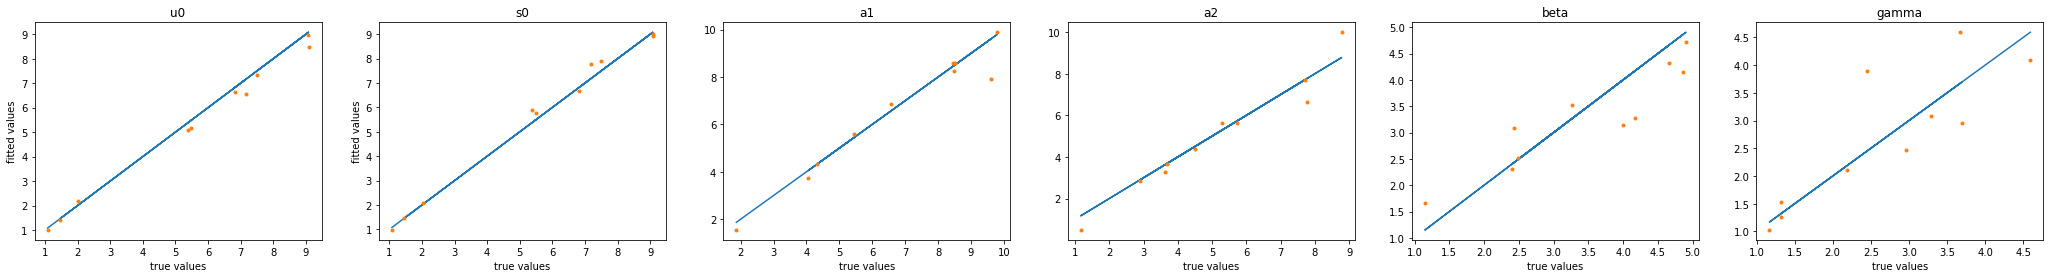

In [10]:
#%% update theta
weight=np.diag(v=[1]*n)
theta_hat=update_theta(X,weight,tau,parallel=True,n_threads=2,theta0=None)

plot_theta(theta,theta_hat,K)

## find posterior

In [19]:
m=1001
weight = update_weight(X,theta,tau,m)

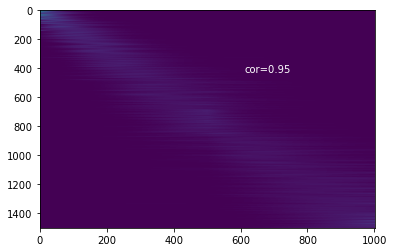

In [20]:
plot_t(weight, ax=None, t=t)

## traj_EM

In [13]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 15
u0 = np.random.uniform(0,10,size=p)
s0 = np.random.uniform(0,10,size=p)
a1 = np.random.uniform(0,10,size=p)
a2 = np.random.uniform(0,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-3]=s0
theta[:,-4]=u0
theta[:,-1]=gamma
theta[:,-2]=beta

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

%time theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 2)

100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.45s/it]

CPU times: user 1.96 s, sys: 792 ms, total: 2.75 s
Wall time: 48.9 s


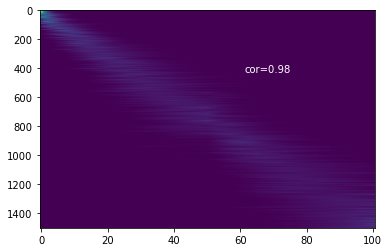

In [14]:
plot_t(weight,ax=None,t=t)

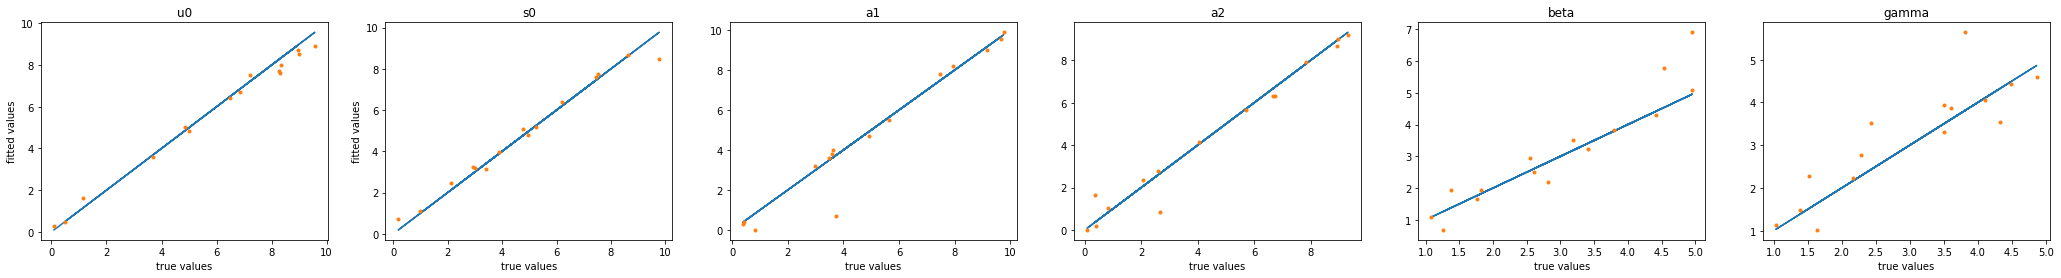

In [15]:
plot_theta(theta,theta_hat,K)

In [25]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 50
u0 = np.random.uniform(0,10,size=p)
s0 = np.random.uniform(0,10,size=p)
a1 = np.random.uniform(0,10,size=p)
a2 = np.random.uniform(0,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-3]=s0
theta[:,-4]=u0
theta[:,-1]=gamma
theta[:,-2]=beta

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

%time theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 40)

100%|███████████████████████████████████████████| 20/20 [01:16<00:00,  3.81s/it]

CPU times: user 5.95 s, sys: 6.09 s, total: 12 s
Wall time: 1min 16s


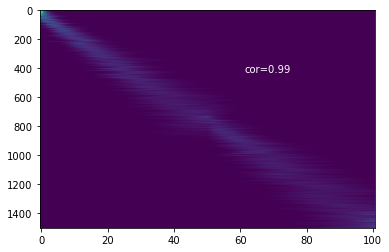

In [42]:
plot_t(weight,ax=None,t=t)

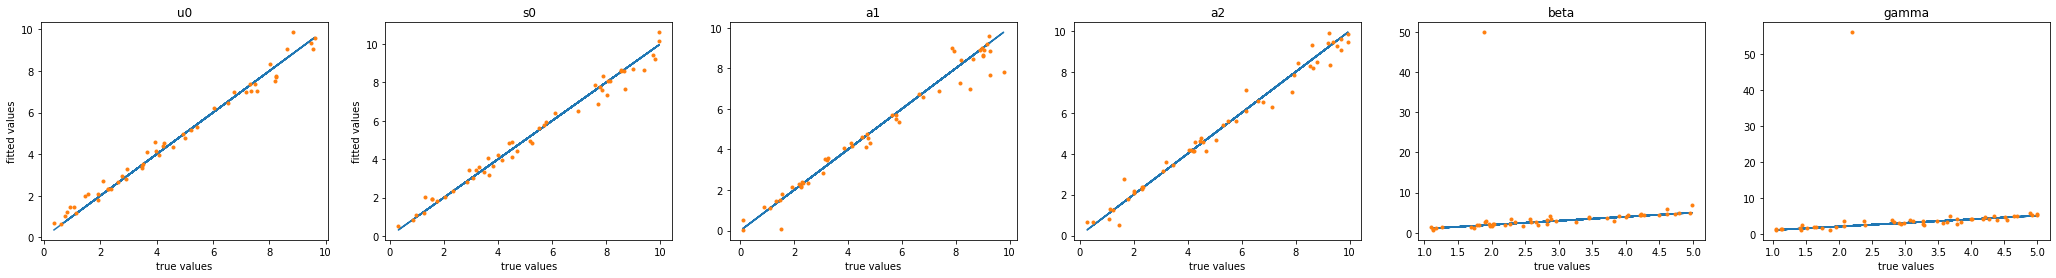

In [43]:
plot_theta(theta,theta_hat,K)

## Requirement on n and p in optimal parameter regimes

An informative gene should have moderate beta and gamma value, not too small so that there are dynamics, and also not too large so that the dynamics are a significant part of data.

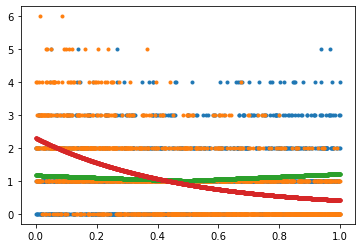

In [83]:
p = 150
n = 1500
np.random.seed(2022)
t = np.linspace(0, 1, n)
tau=(0,0.5,1)
K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=np.random.uniform(0,5,size=p)
theta[:,1]=np.random.uniform(0,5,size=p)
theta[:,-3]=np.random.uniform(0,5,size=p)
theta[:,-4]=np.random.uniform(0,5,size=p)
theta[:,-1]=np.random.uniform(0,3,size=p)
theta[:,-2]=np.random.uniform(0,3,size=p)

Y = get_Y(theta,t,tau)
X = np.random.poisson(Y)
plt.plot(t,X[:,0,],'.');
plt.plot(t,Y[:,0,],'.');

100%|███████████████████████████████████████████| 20/20 [23:55<00:00, 71.76s/it]


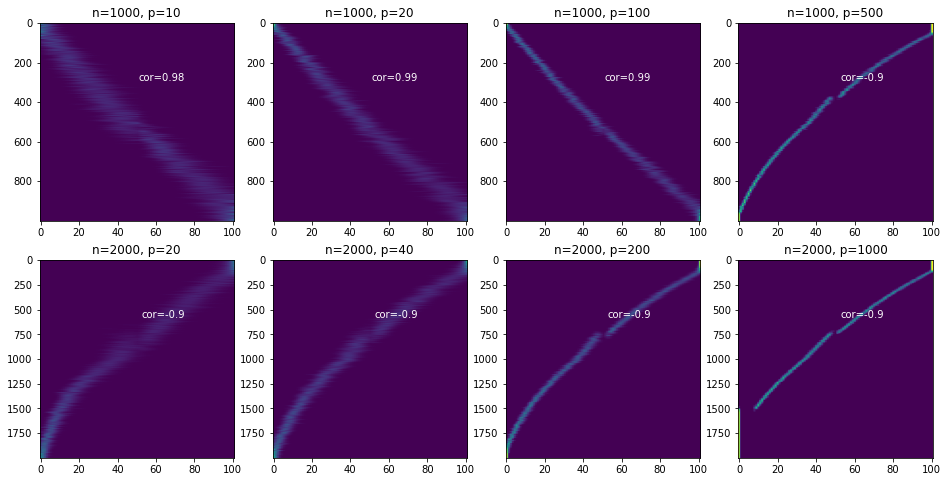

In [21]:
ns=[1500,3000]
rs=[0.01,1/30,0.1]
np.random.seed(2022)
fig, axs = plt.subplots(len(ns), len(rs), figsize=(4*len(rs),4*len(ns)))
for i,n in enumerate(ns):
    for j,r in enumerate(rs): 
        p = int(n*r)
        t = np.linspace(0, 1, n)
        tau=(0,0.5,1)
        K=len(tau)-1
        theta=np.zeros((p,K+4))
        theta[:,0]=np.exp(np.random.uniform(0,6,size=p))
        theta[:,1]=np.exp(np.random.uniform(0,6,size=p))
        theta[:,-3]=np.exp(np.random.uniform(0,6,size=p))
        theta[:,-4]=np.exp(np.random.uniform(0,6,size=p))
        theta[:,-1]=np.random.uniform(1,5,size=p)
        theta[:,-2]=np.random.uniform(1,5,size=p)
        
        Y = get_Y(theta,t,tau)
        X = np.random.poisson(Y)

        theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 40)

        plot_t(weight,axs[i,j],t)
        axs[i,j].set_title("n="+str(n)+", p="+str(p));

100%|███████████████████████████████████████████| 20/20 [00:45<00:00,  2.27s/it]


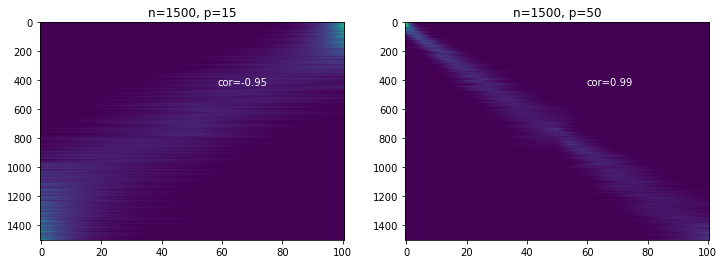

In [29]:
ns=[1500]
rs=[0.01,1/30]#,0.02,0.1]
np.random.seed(2022)
fig, axs = plt.subplots(len(ns), len(rs), figsize=(6*len(rs),4*len(ns)))
for i,n in enumerate(ns):
    for j,r in enumerate(rs): 
        p = int(n*r)
        t = np.linspace(0, 1, n)
        tau=(0,0.5,1)
        K=len(tau)-1
        theta=np.zeros((p,K+4))      
        theta[:,-4]=np.random.uniform(0,10,size=p)
        theta[:,-3]=np.random.uniform(0,10,size=p)
        theta[:,0]=np.random.uniform(0,10,size=p)
        theta[:,1]=np.random.uniform(0,10,size=p)
        theta[:,-1]=np.random.uniform(1,5,size=p)
        theta[:,-2]=np.random.uniform(1,5,size=p)

        Y = get_Y(theta,t,tau)
        X = np.random.poisson(Y)

        theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 40)

        plot_t(weight,axs[j],t)
        axs[j].set_title("n="+str(n)+", p="+str(p));

## What if we include some uninformative genes?

In [ ]:
ns=[1500,3000]
rs=[0.01,0.02,0.1,0.5]
np.random.seed(2022)
fig, axs = plt.subplots(len(ns), len(rs), figsize=(4*len(rs),4*len(ns)))
for i,n in enumerate(ns):
    for j,r in enumerate(rs): 
        p = int(n*r)
        t = np.linspace(0, 1, n)
        tau=(0,0.5,1)
        K=len(tau)-1
        theta=np.zeros((p,K+4))
        theta[:,0]=np.random.uniform(0,100,size=p)
        theta[:,1]=np.random.uniform(0,100,size=p)
        theta[:,-3]=np.random.uniform(0,100,size=p)
        theta[:,-4]=np.random.uniform(0,100,size=p)
        theta[:true_p,-1]=1 #10**np.random.uniform(0,1,size=p)
        theta[:true_p,-2]=1 #10**np.random.uniform(0,1,size=p)
        
        Y = get_Y(theta,t,tau)
        X = np.random.poisson(Y)

        theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 40)

        plot_t(weight,axs[i,j],t)
        axs[i,j].set_title("n="+str(n)+", p="+str(p));

## Wrong tau

In [ ]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 15
u0 = np.random.uniform(1,10,size=p)
s0 = np.random.uniform(1,10,size=p)
a1 = np.random.uniform(1,10,size=p)
a2 = np.random.uniform(1,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

tau=(0,0.5,1)
tau_hat=(0,0.7,1)

K=2
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-4]=u0
theta[:,-3]=s0
theta[:,-2]=beta
theta[:,-1]=gamma

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

m=101
%time theta_hat, weight = traj_EM(X, tau_hat, m=101, epoch=20, parallel = True, n_threads = 2)

CPU times: user 2.45 s, sys: 1.09 s, total: 3.54 s
Wall time: 2min 18s


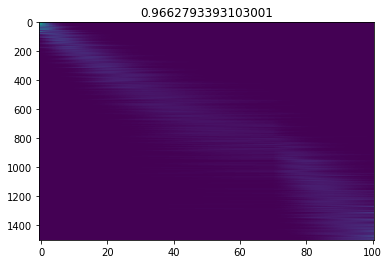

In [ ]:
plot_t(weight,t)

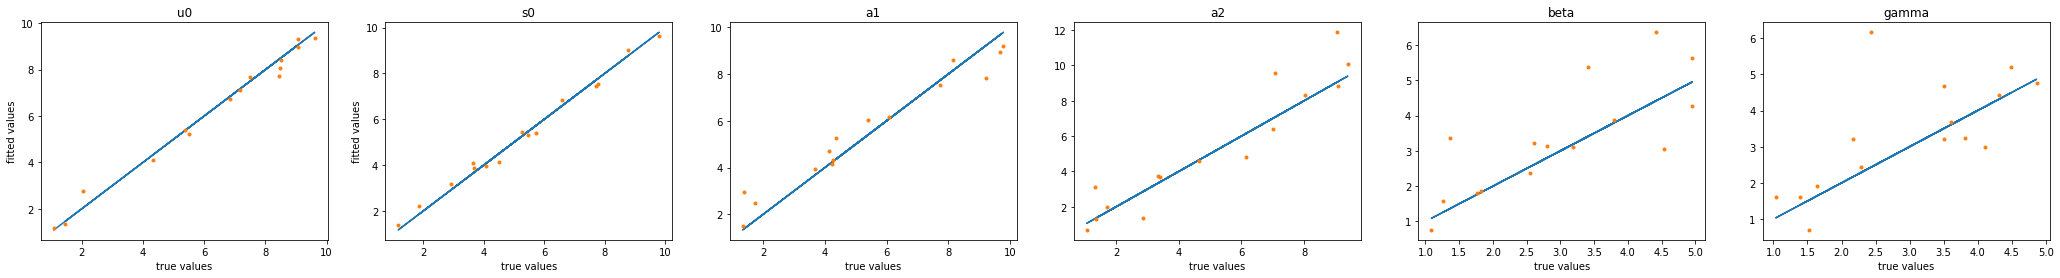

In [ ]:
plot_theta(theta,theta_hat,K)

# Real data

In [84]:
import scvelo as scv

adata = scv.datasets.forebrain()
adata

100%|██████████████████████████████████████| 29.2M/29.2M [00:01<00:00, 22.9MB/s]


AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [85]:
adata.var_names

Index(['FAM138A', 'RP11-34P13.7', 'RP11-34P13.8', 'AL627309.1',
       'RP11-34P13.14', 'AP006222.2', 'RP4-669L17.2', 'RP5-857K21.1',
       'RP5-857K21.3', 'RP5-857K21.4',
       ...
       'BPY2', 'DAZ2', 'AC016752.1', 'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ4',
       'CSPG4P1Y', 'CDY1', 'TTTY3'],
      dtype='object', name='Gene', length=32738)

## Inference with only marker genes

In [119]:
genes=["SOX2","SLC17A7","EOMES","CLU","FBXO32",
       "UNC5D","SEZ6","RBFOX1","DCX","GRIA3",
       "STMN2", "FAM64A","ELAVL4","RNASEH2B"]
idx=adata.var_names.isin(genes)
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

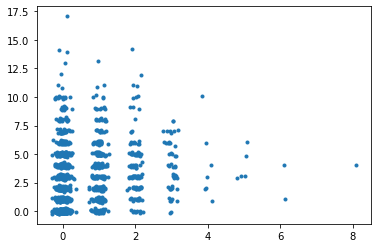

In [120]:
j=0
plt.plot(X[:,j,0]+np.random.normal(scale=0.1,size=n),X[:,j,1]+np.random.normal(scale=0.1,size=n),'.');

### Two states 0.3

In [121]:
theta_hat, weight = traj_EM(X,tau=(0,0.3,1), m=1001, epoch=20, parallel=True, n_threads=14)

100%|███████████████████████████████████████████| 20/20 [08:09<00:00, 24.48s/it]


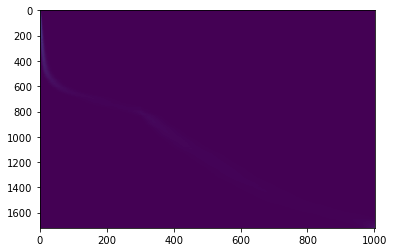

In [122]:
plot_t(weight)

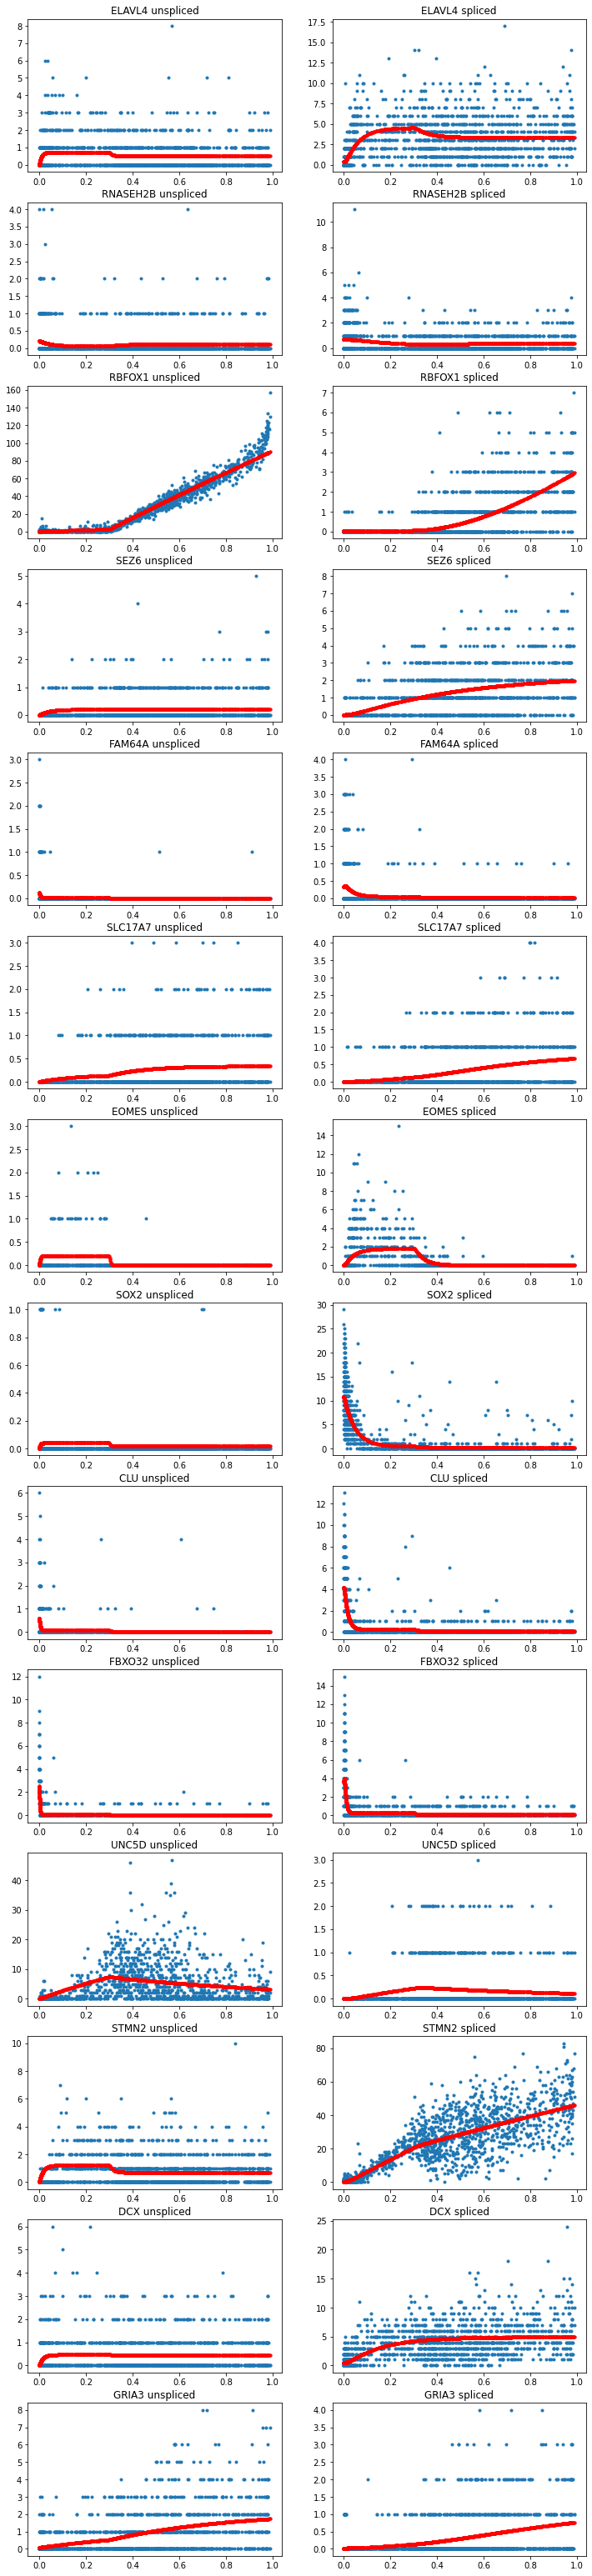

In [123]:
plot_y(theta_hat, weight, (0,0.3,1), gene_list)

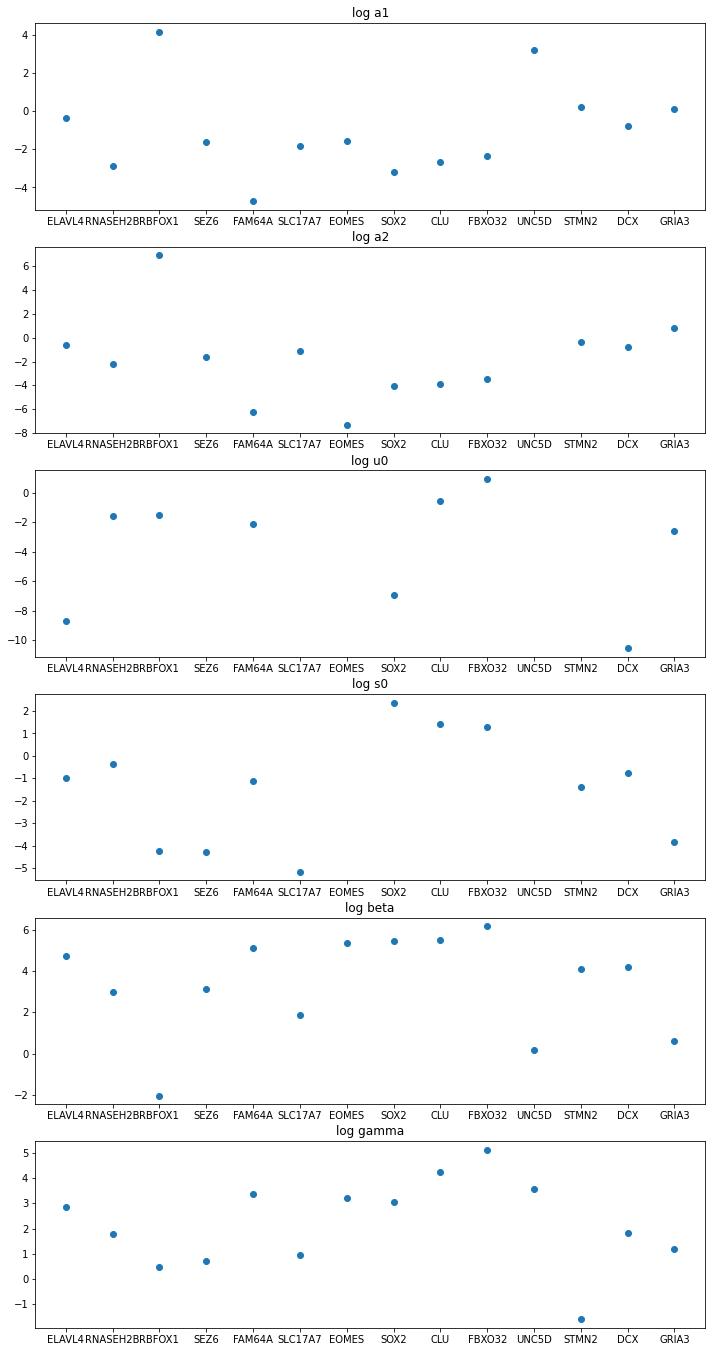

In [124]:
plot_theta_hat(theta_hat,2,gene_list)

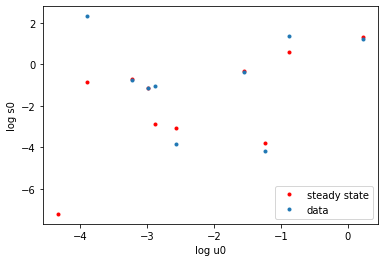

In [ ]:
plt.plot(np.log(theta_hat[:,-4]),np.log(theta_hat[:,-4]*theta_hat[:,-2]/theta_hat[:,-1]),'r.',label="steady state");
plt.plot(np.log(theta_hat[:,-4]),np.log(theta_hat[:,-3]),'.',label="data");
plt.xlabel("log u0")
plt.ylabel("log s0")
plt.legend();

**Check cell size** 

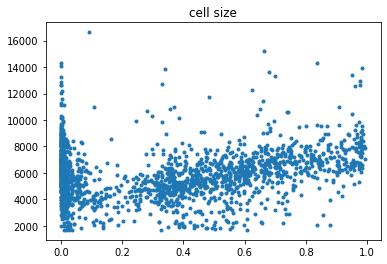

In [ ]:
m=np.shape(weight)[1]
h=np.linspace(0,1,m)
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(adata.layers["spliced"],axis=1),'.');
plt.title("cell size");

## Use many non poisson genes

In [86]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

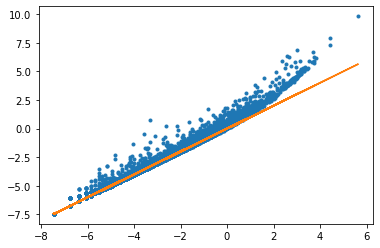

In [95]:
mu = np.mean(S,axis=0)
var = np.mean((S-mu[None,:])**2,axis=0)
plt.plot(np.log(mu),np.log(var),'.')
plt.plot(np.log(mu),np.log(mu))

In [98]:
idx=mu>np.exp(2)
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s
np.shape(X)

(1720, 118, 2)

In [99]:
theta_hat, weight = traj_EM(X,tau=(0,0.3,1), m=101, epoch=20, parallel=True, n_threads=40)

100%|███████████████████████████████████████████| 20/20 [02:28<00:00,  7.44s/it]


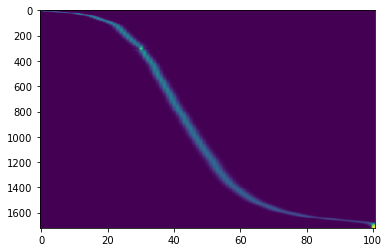

In [100]:
plot_t(weight)

IndexError: index 13 is out of bounds for axis 0 with size 13

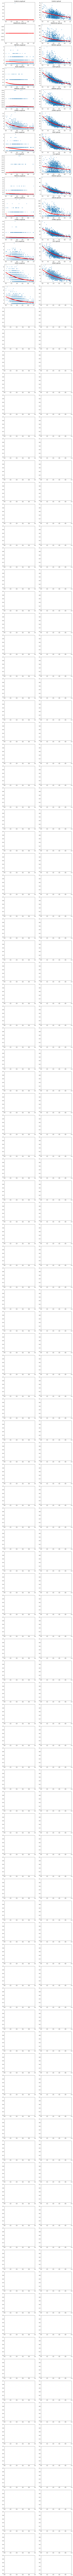

In [101]:
plot_y(theta_hat, weight, (0,0.3,1), marker_genes)